![](https://joealves.com/wp-content/uploads/2017/12/yelp-logo-22.png)

- <a href='#1'>1. Introduction</a>  
- <a href='#2'>2. Loading Libraries</a>
- <a href='#3'>3. Retrieving the Data</a>
- <a href='#4'>4. Prepare data for modeling</a>
- <a href='#5'>5. Let's look at the Data</a>
- <a href='#6'>6. Model with two users</a>
- <a href='#7'>7. Final Model</a>

# <a id='1'>1. Introduction</a>

This model follows the following structure:

1. A User (User A) visits a Restaurant's Yelp page (Business 1)
2. We find all users that review that restuarant
3. We then find all reviews (for all restuarants) of the users who reviewed Business 1
4. We train a TFIDF on all those reviews
5. We calculate the similarity of User A to all users within each independent business to get numeric value for entire matrix
6. We calculate the simlarity for User A to all user for all businesses
7. We find the N most similar users and average their ratings
8. We calculate the RMSE of averaged rating of similar user to actual users to get model error

 # <a id='2'>2. Loading Libraries</a>

In [1]:
import pandas as pd
import numpy as np
import collections
import os
from timeit import default_timer as timer
import time
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics

import matplotlib.pyplot as plt

# first-time use only
# nltk.download('wordnet') 
# nltk.download('punkt')

# Sandbox to explore model, step by step

 # <a id='3'>3. Retrieving the Data</a>

In [20]:
path_to_data = "C:/Users/Ephraim/Desktop/Method Data Science/yelp-reviews.csv"
orig_df = pd.read_csv(path_to_data, encoding = "ISO-8859-1")

In [22]:
orig_df.head()

,column_a,business_blank,business_categories,business_city,business_full_address,business_id,business_latitude,business_longitude,business_location,business_name,...,reviewer_funny,reviewer_name,reviewer_review_count,reviewer_type,reviewer_useful,stars,text,type,useful,user_id
0,0,False,Breakfast & Brunch; Restaurants,Phoenix,"6106 S 32nd St\nPhoenix, AZ 85042",9yKzy9PApeiPPOUJEtnvkg,33.390792,-112.012504,POINT(-112.012504 33.390792),Morning Glory Cafe,...,331,Jason,376,user,1034,5,My wife took me here on my birthday for breakf...,review,5,rLtl8ZkDX5vH5nAx9C3q5Q
1,1,False,Italian; Pizza; Restaurants,Phoenix,"4848 E Chandler Blvd\nPhoenix, AZ 85044",ZRJwVLyzEJq1VAihDhYiow,33.305607,-111.978758,POINT(-111.9787576 33.3056067),Spinato's Pizzeria,...,2,Paul,2,user,0,5,I have no idea why some people give bad review...,review,0,0a2KyEL0d3Yb1V6aivbIuQ
2,1000,False,Restaurants; Italian,Phoenix,"2 E Jefferson St\nSte 113\nPhoenix, AZ 85004",vfLog2bLJGl6hAFtGtr0GQ,33.447173,-112.073781,POINT(-112.073781 33.4471735),The Strand,...,8,Ellin,201,user,58,4,Great atmosphere with interesting lights (look...,review,0,3ltazFFclBfchSYlctX6iA
3,10000,False,Mexican; Restaurants,Phoenix,"1812 E Camelback Rd\nPhoenix, AZ 85016",ib-y5nsfn3unE0lLY1vfAw,33.509702,-112.042514,POINT(-112.042514 33.509702),Arriba Mexican Grill,...,2,J- Lee,30,user,29,3,"I liked, it was spicy, the beans and hot sauce...",review,3,XOST6fNtPAUg_0JJo5ai6w
4,100001,False,Restaurants; Sandwiches; Italian,Phoenix,"2605 N 7th St\nPhoenix, AZ 85006",PwtYeGu-19v9bU4nbP9UbA,33.477040,-112.064907,POINT(-112.0649071 33.4770399),Calabria Italian Kitchen,...,205,Ceci,403,user,752,5,We were a group of more than 25 CSers and we f...,review,2,LqgGgWi3FLHBViX9tmZ9sw


 # <a id='4'>4. Prepare data for modeling</a>

In [23]:
# Pivot the data to create a User - Business matrix

df1 = orig_df.groupby(['user_id', 'business_id'])['text'].max().unstack()

In [24]:
# We also want to calculate the similarities between all the texts from all the users

df1['all_text'] = df1.apply(lambda x: ','.join(x.dropna().astype(str)), axis=1)

 # <a id='5'>5. Let's look at the Data</a>

In [25]:
print( df1.shape)
df1.head(10)

(19795, 1630)


business_id,-0QBrNvhrPQCaeo7mTo0zQ,-0bUDim5OGuv8R0Qqq6J4A,-1bOb2izeJBZjHC7NWxiPA,-3WVw1TNQbPBzaKCaQQ1AQ,-3xbryp44xhpN4BohxXDdQ,-7XuLxfYwZ9x72mEKXdv0A,-8wyZkzfBmCFkMwCGcR4PQ,-98noPZy1sH6NndWmdtuDw,-AAig9FG0s8gYE4f8GfowQ,-JpZiiGPKOuCEiODGNyovw,...,zht8__JJoxkozBhf_vuKYg,ziaSXim-Om_a62V7X0GSpQ,zmFc8M-hS4uuyY0hklIpoQ,zmjWXerSZlB0eRLxrKevYQ,znBnrQNq1FdUt5aIGAbyuQ,zn_gLMU-Lr3wleSPd-nmbg,zp713qNhx8d9KCJJnrw1xA,zv92SeuVPQdof0PdgN056g,zwHM6hz8swKIG-4-BSKMPA,all_text
user_id,,,,,,,,,,,,,,,,,,,,,
--65q1FpAL_UQtVZ2PTGew,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,La Condesa is an amazing little spot that has ...,None,None,I just got back from doing their Lava Challeng...
--M-cIkGnH1KhnLaCOmoPQ,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,I went here twice when I visited Phoenix in la...
--RD0Z_F0tV4L-AzhOzXYA,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,We went for the lunch special. Most of it is p...
--VxRvXk3b8FwsSbC2Zpxw,None,None,None,None,None,None,None,None,None,None,...,None,CLOSED forever...Too bad\n\n\nA-Town is great ...,None,None,None,None,None,None,None,"Good sandwich! Better than all the chains, doe..."
--dofeOsROFpm0q_dmqTTA,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,I ABSOLUTELY LOVE this place! Their Lebanese C...
-01H9S7YxFrhRgNdvxmaVQ,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,Good food. Service is sometimes not great but ...
-06LYbA4Qm_9E83KNT1Jrg,None,None,None,None,None,None,None,None,In town for a Spring Training trip and had a d...,None,...,None,None,None,None,None,None,None,None,None,In town for a Spring Training trip and had a d...
-0gh7015nDOhZlwzlNNxwA,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,I love this place. Best Horchata in Phoenix (y...
-2PFmYGWB6rQhZtRh6PlPA,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"Like their happy hour stuff, pretty good sushi..."


In [26]:
# Let's check which users wrote the most reviews
df1.apply(lambda x: x.count(), axis=1).sort_values(ascending = False)

user_id
ikm0UCahtK34LbLCEw4YTw    171
C6IOtaaYdLIT5fWd7ZYIuA    166
JgDkCER12uiv4lbpmkZ9VA    161
vhxFLqRok6r-D_aQz0s-JQ    129
usQTOj7LQ9v0Fl98gRa3Iw    127
M6oU3OBf_E6gqlfkLGlStQ    118
0mqHhdKEdak_A1FBhFNXqA    117
q9XgOylNsSbqZqF_SO3-OQ    116
htC49ZwXiKNka5cp0GKBfQ    115
fczQCSmaWF78toLEmb0Zsw    114
3gIfcQq5KxAegwCPXc83cQ    112
XBHJCDzNh--mBhJkzyM_iA    108
lPaYMDmJbAnv_3pmZH_inw    105
W_QXYA7A0IhMrvbckz7eVg    104
gcyEUr4DXcbjnGRAWFtfAQ    103
C8ZTiwa7qWoPSMIivTeSfw    102
17PPxx8RxjOUD_nQZ1aHEw    100
78Ed1ndOak2kmzljulPfBg     99
vsXP832M0kOxKpfduD7dWw     98
fev0iI-XDrteD4SYRKjiUw     97
pEVf8GRshP9HUkSpizc9LA     95
_PzSNcfrCjeBxSLXRoMmgQ     93
0CMz8YaO3f8xu4KqQgKb9Q     92
6kmu0mYbdpMIOZ6Y0eVsxg     90
Iycf9KNRhxvR187Qu2zZHg     90
6ts41fCsDKHbFZaKOMNmVQ     89
33vUIil_GCaT92aUaZhRXA     86
SGXahHRReksq3m_Zk9V20w     85
0bNXP9quoJEgyVZu9ipGgQ     84
XqMkm-DD9VsdcKx2YVGhSA     83
                         ... 
Zq1J3jo27l5m2ntTZPOSgA      2
ZpzktAWuUgqlSKgIk0wX8A      2
Zx

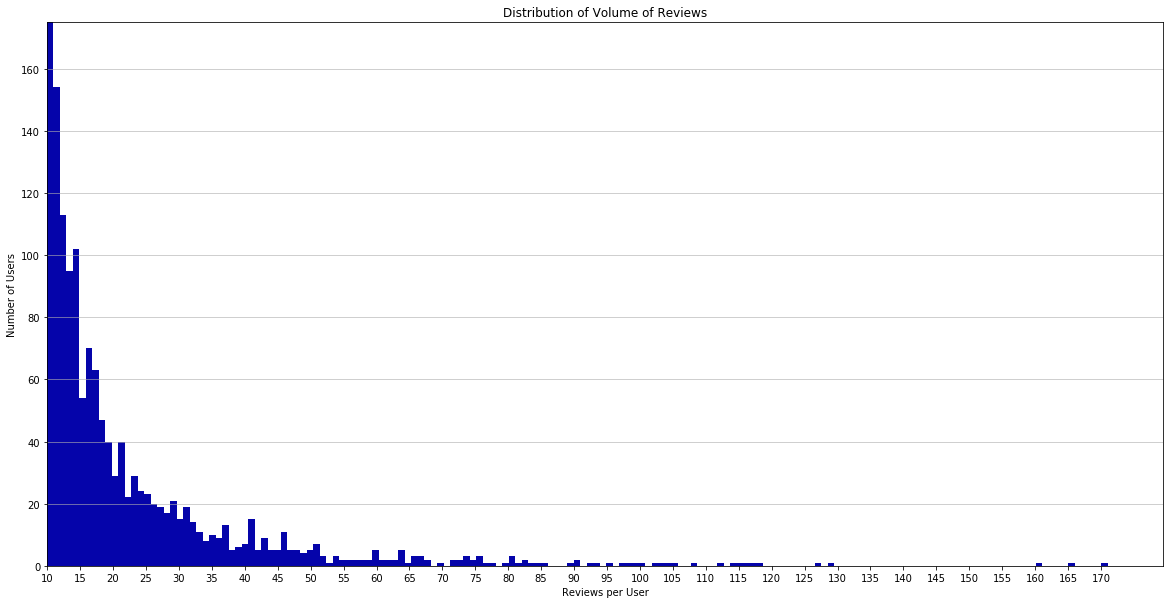

In [27]:
# And lets check the distribution
plt.figure(figsize=(20,10))
review_count = df1.apply(lambda x: x.count(), axis=1)
n, bins, patches = plt.hist(x=review_count, 
                            bins=review_count.max(), color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Reviews per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Volume of Reviews')
# Set a clean upper y-axis limit.
plt.ylim(ymax=175)
plt.xlim(xmin=10)
plt.xticks(range(10, 175, 5))
plt.show()

 # <a id='6'>6. Model with two users</a>

In [28]:
# Let's pick the top two users
users = df1.apply(lambda x: x.count(), axis=1).sort_values(ascending = False)[0:2].index

In [29]:
# Before we run the loop, we want to try it out with one user

userA = users[0]

In [30]:
# This fuction selects the businesses that our user reviewed

def businesses_to_test(orig_df, user):
    business_ids = orig_df[orig_df['user_id'] == user]['business_id']
    business_ids = business_ids.unique().tolist()
    
    return business_ids

In [31]:
# Let's select the businesses that User A reviewed

business_ids = businesses_to_test(orig_df, userA)

In [32]:
# This functions makes sure our user is the top row
# so that every other row is calculated compared to it

def sort_df(df, user):
    a = (df.index.values != user).argsort(kind='mergesort')
    df = pd.DataFrame(df.values[a], df.index.values[a], df.columns)
    
    return df

In [33]:
# This fuction filters our dataframe to just the businesses
# that our user reviewed

def filter_df(df, business_ids, user):
    filtered_df = df[business_ids]
    filtered_df = pd.merge(filtered_df, df[['all_text']], right_index=True, left_index=True)
    filtered_df = sort_df(filtered_df, user)
    
    return filtered_df

In [13]:
# And now let's filter the dataset by the businesses that User A reviewed

filtered_df = filter_df(df1, business_ids, userA)

In [ ]:
# View the dataset that has been subsetted

filtered_df.dropna(how='all')

In [34]:
def flatten(x):
    result = []
    for el in x:
        if isinstance(x, collections.Iterable) and not isinstance(el, str):
            result.extend(flatten(el))
        else:
            result.append(el)
    return result

In [35]:
def preprocess_text(df):
    processed_text = df.dropna(how='all').str.lower()
    processed_text = processed_text.replace('\n',' ').replace('/a',' ')
    processed_text = processed_text.str.translate(str.maketrans('', '', string.punctuation))
    processed_text = processed_text.str.translate(str.maketrans('', '', string.digits))

    return processed_text

In [36]:
# This function turns words into tokens and reduces words to their stems
# It is used as an imput for the TFIDF Vectorizer

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
        
    return stems

In [37]:
# Process
# 1. preprocess 'all text'
# 2. train tdidf on 'all text'
# 3. loop through columns
# 4. preprocess columns
# 5. transform tfidf
# 6. calculate similarity on column

def build_tfidf_dict(df):
    text_for_tfidf = preprocess_text(df['all_text'])
    text_for_tfidf = text_for_tfidf.values.tolist()
    text_for_tfidf = flatten(text_for_tfidf)
    tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
    tfidf_vectorizer = tfidf_vectorizer.fit(text_for_tfidf)

    return tfidf_vectorizer

In [14]:
tfidf_vectorizer = build_tfidf_dict(filtered_df)

In [ ]:
# This function goes column by column and gets the cosine similarity
# for each review for that single column (business)

def get_bus_similarities(filtered_df):
    for col in list(filtered_df.columns):
        text = preprocess_text(filtered_df[col].dropna(how='all'))

        tfidf_matrix = tfidf_vectorizer.transform(text)
        sim_array = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)
        filtered_df.loc[text.index, col] = pd.DataFrame(sim_array.tolist()[0], index=text.index)[0]
        
    return filtered_df

In [15]:
# Calculate the similarities between User A's to all other review for each business

filtered_df = get_bus_similarities(filtered_df)

In [16]:
# Now that we replaced text with values, let's view the dataset

filtered_df[business_ids].dropna(how='all')

business_id,podj1OWSL3oEJsOpGj8SUw,LzpR_jE6VIutJ08s2cdRrw,-sC66z4SO3tR7nFCjfQwuQ,mqQwChPNN4o4DhAzaGntIA,1NZLxU5WvB5roPFzneAlLw,q1nDSpmV-FdTBNj6UuZvTg,VXIkI9_EbDbYHeO9IzKjJg,M6fjHpkL9IRI-nI0BattRw,mTjHcl-pkNO4iOKY8rVHPw,wZwZcte4lcbu51NOzCjWbQ,...,BESmH-lmMm34_EefL8X9fQ,-3WVw1TNQbPBzaKCaQQ1AQ,QPheu9dnwdlaPwXofP8ijw,qjmCVYkwP-HDa35jwYucbQ,MLcXtnpzygZvQ9BtseLLlw,VVeogjZya58oiTxK7qUjAQ,IceZ4BtTz76eppjNWm-c6A,AaKlegu7gmOCD4rEESF76Q,TfTlOE6h9E9o34dEkw9L_w,r8CwFUEQtL8gAT9KHnNhuw
zgCO0TnkvfohTmwPTwP7Ew,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
--65q1FpAL_UQtVZ2PTGew,None,None,0.0441036,0.0397563,0.250762,None,None,0.131893,None,None,...,None,None,None,None,None,0.283227,None,0.0364662,None,0.162132
-06LYbA4Qm_9E83KNT1Jrg,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-0gh7015nDOhZlwzlNNxwA,None,None,None,None,None,None,0.214487,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-2VqtJTmSoGFQWFIuJVZzg,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-2gxrMHX8_F1Ep_ppWYTkw,None,None,None,None,None,None,None,0.125083,None,None,...,None,None,None,None,None,None,None,None,None,None
-3HkgwyxVPf49MXM4dT8Tw,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,0.234694,None
-50fOYTeDK4_9m4gZLHaIg,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,0.152349,None
-533euPHZXG982IzgFjZCw,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-7LfdqX286W8zJ01ljY_SQ,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
# This function filters by the top 5 similar users 
# and averages the scores

def get_scores(sim_df, business, orig_df, num_reviews):
    df = pd.merge(sim_df, orig_df[orig_df['business_id']==business][['user_id', 'stars']], 
               left_index=True, right_on='user_id')
    df = df[1:].nlargest(num_reviews, 0)
    score_set = [df['stars'].mean(), df.iloc[0, 2]]

    return score_set

In [ ]:
# This function calculates the similarity by rows (users)

def get_user_similarities(filtered_df, business_ids, user, orig_df, num_reviews):
    df = filtered_df[business_ids].dropna(how='all')
    df = sort_df(df, user)
    df = df.fillna(0)
    
    sim_df = cosine_similarity(df[0:1], df)
    sim_df = pd.DataFrame(sim_df).T
    sim_df.index = df.index.values.tolist()
    
    scores = []
    for business in business_ids:
        score_set = get_scores(sim_df, business, orig_df, num_reviews)
        scores.append(score_set)
    
    return scores

In [18]:
# Calculate the similarity between User A and all other users

scores = get_user_similarities(filtered_df, business_ids, userA, orig_df, 5)

In [39]:
# Taking a look at the final dataset that we will calcuate accuracy on

scores = pd.DataFrame(scores, columns=['predicted', 'actual'])

In [41]:
# Calculating Accuracy of our model
print(np.sqrt(metrics.mean_squared_error(scores[['actual']], scores['predicted'])))

0.832666399786


In [44]:
# Main function with two users:
# Iterate through each user and calculate average rating of top five similar users
# And then add that data to list that stores for all users that we iterate through

all_scores = []
start_time = timer()
print('Start Time: ' + time.strftime("%X", time.gmtime()))

# Iterate through each user and get all avg ratings of top N users along with users rating for each business that user reviewed
for idx, user in enumerate(users):
    start = timer()
    
    # Find businesses that user reviewed
    print(time.strftime("%X", time.gmtime()) + ' - User: ' + str(idx+1) + ' of ' + str(len(users)) + '; segmenting businesses')
    business_ids = businesses_to_test(orig_df, user)
    
    # Filter dataframe by businesses that user reviewed
    print(time.strftime("%X", time.gmtime()) + ' - User: ' + str(idx+1) + ' of ' + str(len(users)) + '; filtered dataset')
    filtered_df = filter_df(df1, business_ids, user)
    
    # Calculate similarities of reviews within each business
    print(time.strftime("%X", time.gmtime()) + ' - User: ' + str(idx+1) + ' of ' + str(len(users)) + '; got business similarities')
    filtered_df = get_bus_similarities(filtered_df)
    
    # Calculate cosine similarity between user and all other users
    print(time.strftime("%X", time.gmtime()) + ' - User: ' + str(idx+1) + ' of ' + str(len(users)) + '; got user similarities')
    scores = get_user_similarities(filtered_df, business_ids, user, orig_df, 5)
    
    # Append avged rating and user rating to master list 
    print(time.strftime("%X", time.gmtime()) + ' - User: ' + str(idx+1) + ' of ' + str(len(users)) + '; appended scores')
    all_scores.append(scores)
    
    end = timer()
    print(time.strftime("%X", time.gmtime()) + ' - User: ' + str(idx+1) + ' of ' + str(len(users)) + '; time run: ' + str(end - start))

# Flatten list of lists and put in dataframe
all_scores = pd.DataFrame([y for x in all_scores for y in x], columns=['predicted', 'actual'])

# Calculate the RMSE of our model
Accuracy = np.sqrt(metrics.mean_squared_error(all_scores['actual'], all_scores['predicted']))

print('Total Time: ' + str(timer() - start_time))
print('RMSE = ' + str(Accuracy))

Start Time: 03:54:54
03:54:54 - User: 1 of 2; segmenting businesses
03:54:54 - User: 1 of 2; filtered dataset
03:54:54 - User: 1 of 2; got business similarities
04:00:56 - User: 1 of 2; got user similarities
04:00:59 - User: 1 of 2; appended scores
04:00:59 - User: 1 of 2; time run: 365.06926802754606
04:00:59 - User: 2 of 2; segmenting businesses
04:00:59 - User: 2 of 2; filtered dataset
04:00:59 - User: 2 of 2; got business similarities
04:06:57 - User: 2 of 2; got user similarities
04:06:59 - User: 2 of 2; appended scores
04:06:59 - User: 2 of 2; time run: 360.449170959577
Total Time: 725.5212110826702
RMSE = 0.857783599255


In [ ]:
# Building the final prediction - actual rating dataset for multiple users

all_scores = pd.DataFrame([y for x in all_scores for y in x], columns=['predicted', 'actual'])

In [ ]:
# Taking a look at that dataset

all_scores

In [40]:
# Calculating Accuracy of our model
print(np.sqrt(metrics.mean_squared_error(scores[['actual']], scores['predicted'])))

0.832666399786


 # <a id='7'>7. Final Model</a>

This is the final code - setting up each of the functions and then goes through all the steps.  

In [17]:
"""
Function to import/prepare necessary dataframes

INPUTS:
path:           Path to dataframe

RETURNS:        Three dataframes: original dataframe without any manipulation
                subset dataframe that just picks out relevant columns
                and pivoted dataframe to create user-business dataframe 
                and adds column for all reviews by user aggregated in one cell
"""

def prepare_data(path):
    
    # Read in data
    orig_df = pd.read_csv(path, encoding = "ISO-8859-1")
    
    # Pivot the data to create User - Restaurant matrix
    df1 = orig_df.groupby(['user_id', 'business_id'])['text'].max().unstack()
    
    # Add in column that is all the reviews per user
    df1['all_text'] = df1.apply(lambda x: ','.join(x.dropna().astype(str)), axis=1)

    return orig_df, df1

"""
Function that brings back a list of users who have reviewed at least 15 restaurants

INPUTS:
df:             The pivoted DataFrame

RETURNS:        List of users
"""

def find_users(df):
    
    # Get the count of reviews per user
    review_count = df.apply(lambda x: x.count(), axis=1)
    
    # Filter dataset by users who have more than 15 reviews
    review_count = review_count[review_count>15] 
    
    # Return list of user ids who have more than 15 reviews
    users = review_count.index.sort_values(ascending = False).tolist()

    return users

"""
Fuction to select the businesses that user in question reviewed in order to subset our data.

INPUTS:
orig_df:        The original Pandas DataFrame of all the data imported from json/csv before pivot
user:           User ID of user in question as a string

RETURNS:        List of Business IDs
"""

def businesses_to_test(orig_df, user):
    
    # Get list of business ids that our user reviewed
    business_ids = orig_df[orig_df['user_id'] == user]['business_id']
    
    # Return a list of those businesses
    business_ids = business_ids.unique().tolist()
    
    return business_ids

"""
Functions makes sure our user is the top row so that every other row is calculated compared to it.
This ensures that we are not calculating every user to every user, but just the user in question

INPUTS:
df:             Pandas DataFrame

RETURNS:        Sorted Pandas DataFrame with user in question in top row
"""

def sort_df(df, user):
    
    # Separate all users that are not our user
    a = (df.index.values != user).argsort(kind='mergesort')
    
    # Return dataframe with our user firse and then every other user
    df = pd.DataFrame(df.values[a], df.index.values[a], df.columns)
    
    return df

"""
Fuction that filters our dataframe to just the businesses that our user reviewed

INPUTS:
df:             Pivoted Pandas DataFrame
business_ids:   List of Business Ids that user reviewed

RETURNS:        A filtered Pandas DataFrame of just businesses that user in question revered 
                and all users that reviewed any of those businesses
"""

def filter_df(df, business_ids, user):
    
    # Filter dataframe by businesses that our user reviewed
    filtered_df = df[business_ids]
    
    # Include column that aggregates all reviews of every user for every business
    filtered_df = pd.merge(filtered_df, df[['all_text']], right_index=True, left_index=True)
    
    # Sort dataframe so that our user is first
    filtered_df = sort_df(filtered_df, user)
    
    return filtered_df

"""
Function to flatten list of reviews into one string

INPUTS:
x:              List of reviews

RETURNS:        List of a single string
"""

def flatten(x):
    
    # Initiate empty list
    result = []
    
    # Iterate through lists
    for el in x:
        if isinstance(x, collections.Iterable) and not isinstance(el, str):
            result.extend(flatten(el))
        else:
            result.append(el)
            
    return result

"""
Function to process the text, removing digits, puntuation, and new lines

INPUTS:
x:              List of single string of words

RETURNS:        List of processed text
"""

def preprocess_text(df):
    
    # Lowercase all words
    processed_text = df.dropna(how='all').str.lower()
    
    # Remove all carriage returns
    processed_text = processed_text.replace('\n',' ').replace('/a',' ')
    
    # Remove puntuation
    processed_text = processed_text.str.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    processed_text = processed_text.str.translate(str.maketrans('', '', string.digits))

    return processed_text

"""
Function turns words into tokens and reduces words to their stems,
It is used as an imput for the TFIDF Vectorizer

INPUTS:
text:           The review to be tokenized

RETURNS:        Returns a set of tokens that have been stemmed
"""

def tokenize(text):
    
    # Create bag of words
    tokens = nltk.word_tokenize(text)
    
    # Reduce each word to its stem
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
        
    return stems

"""
Function to build TFIDF dictionary from entire corpus

INPUTS:
df:             Dataframe of strings of text

RETURNS:        Trained TFIDF vectorizer
"""

def build_tfidf_dict(df):
    
    # Preprocess text
    text_for_tfidf = preprocess_text(df['all_text'])
    
    # List all values
    text_for_tfidf = text_for_tfidf.values.tolist()
    
    # Flatten to return single string of all text
    text_for_tfidf = flatten(text_for_tfidf)
    
    # Build vectorizer implementing tokenizer and removing stopwords
    tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
    
    # Train vectorizer
    tfidf_vectorizer = tfidf_vectorizer.fit(text_for_tfidf)

    return tfidf_vectorizer

"""
Function goes column by column, processes the text, computes the TFIDF,
and gets the cosine similarity for each review for that single column (business)

INPUTS:
filtered_df:    Pivoted Pandas DataFrame with only businesses that user reviewed

RETURNS:        Same DataFrame as Input but the values are cosine similarity values instead of text
"""

def get_bus_similarities(df):
    
    # Iterate through every business to predict what our user would have rated for that business
    for col in list(df.columns):
        
        # Preprocess the text with function above
        text = preprocess_text(df[col].dropna(how='all'))
        
        # Implement TFIDF that was trained on entire corpus
        tfidf_matrix = tfidf_vectorizer.transform(text)
        
        # Calculate similarity between our user and all other users
        sim_array = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)
        
        # Input similarity value back into original dataframe
        filtered_df.loc[text.index, col] = pd.DataFrame(sim_array.tolist()[0], index=text.index)[0]
        
    return filtered_df

"""
Function that filters by the top 5 similar users and averages the scores 
To be used in the function get_user_similarities

INPUTS:
sim_df:         An array of cosine similarities between user in question and every other user
business:       String - Business ID of business we are trying to predict rating for
orig_df:        The original Pandas DataFrame of all the data imported from json/csv before pivot
num_reviews:    The number of reviews that we want to aggregate to predict rating

RETURNS:        List of two values - predicted value and actual rating of user for that business
"""

def get_scores(sim_df, business, orig_df, num_reviews):
    
    # Concatenate our similarity matrix with the ratings for the restaurant
    df = pd.merge(sim_df, orig_df[orig_df['business_id']==business][['user_id', 'stars']], 
               left_index=True, right_on='user_id')
    
    # Filter database by the top N similar reviews
    df = df[1:].nlargest(num_reviews, 0)
    
    # Return a list with just the average of the top N ratings and our user's rating
    score_set = [df['stars'].mean(), df.iloc[0, 2]]

    return score_set

"""
Function calculates the similarity by rows (users)

INPUTS:
filtered_df:    Pivoted Pandas DataFrame with only businesses that user reviewed
business_ids:   List of Business Ids that user reviewed
orig_df:        The original Pandas DataFrame of all the data imported from json/csv before pivot
num_reviews:    The number of reviews that we want to aggregate to predict rating

RETURNS:        List of lists of all the predicted values and actual ratings of user for all businesses user reviewed.
"""

def get_user_similarities(filtered_df, business_ids, user, orig_df, num_reviews):
    
    # Filter our dataframe by just the businesses our user reviewed
    df = filtered_df[business_ids].dropna(how='all')
    
    # Sort so that our user is on top
    df = sort_df(df, user)
    
    # Impute the null values with 0 - TO BE RESEARCHED: Matrix Factorization
    df = df.fillna(0)
    
    # Calculate similarity between our user and every other user for all businesses
    sim_df = cosine_similarity(df[0:1], df)
    
    # Return a transposed dataframe for the similarities values
    sim_df = pd.DataFrame(sim_df).T
    
    # Return a list of the user ids for the similarities
    sim_df.index = df.index.values.tolist()
    
    # Store ratings to compute RMSE
    scores = []
    
    # Loop through all businesses to calculate similarities and return avg score of top N reviewers
    for business in business_ids:
        
        # Employ get_score function above to get avg rating and our user's rating
        score_set = get_scores(sim_df, business, orig_df, num_reviews)
        
        # Append to get final list of all rating comparisons from all businesses our user reviewed
        scores.append(score_set)
    
    return scores

In [ ]:
# Read in the data and set up dataframes
orig_df, df1 = prepare_data("C:/Users/Ephraim/Desktop/Method Data Science/Tor_res_reviews.csv")

# For the final trial, let's test all the users that have above 15 reviews
users = find_users(df1)

all_scores = []
start_time = timer()
print('Start Time: ' + time.strftime("%X", time.gmtime()))

# Iterate through each user and get all avg ratings of top N users along with users rating for each business that user reviewed
for idx, user in enumerate(users):
    start = timer()
    
    # Find businesses that user reviewed
    print(time.strftime("%X", time.gmtime()) + ' - User: ' + str(idx+1) + ' of ' + str(len(users)) + '; segmenting businesses')
    business_ids = businesses_to_test(orig_df, user)
    
    # Filter dataframe by businesses that user reviewed
    print(time.strftime("%X", time.gmtime()) + ' - User: ' + str(idx+1) + ' of ' + str(len(users)) + '; filtered dataset')
    filtered_df = filter_df(df1, business_ids)
    
    # Calculate similarities of reviews within each business
    print(time.strftime("%X", time.gmtime()) + ' - User: ' + str(idx+1) + ' of ' + str(len(users)) + '; got business similarities')
    filtered_df = get_bus_similarities(filtered_df)
    
    # Calculate cosine similarity between user and all other users
    print(time.strftime("%X", time.gmtime()) + ' - User: ' + str(idx+1) + ' of ' + str(len(users)) + '; got user similarities')
    scores = get_user_similarities(filtered_df, business_ids, user, orig_df, 5)
    
    # Append avged rating and user rating to master list 
    print(time.strftime("%X", time.gmtime()) + ' - User: ' + str(idx+1) + ' of ' + str(len(users)) + '; appended scores')
    all_scores.append(scores)
    
    end = timer()
    print(time.strftime("%X", time.gmtime()) + ' - User: ' + str(idx+1) + ' of ' + str(len(users)) + '; time run: ' + str(end - start))

# Flatten list of lists and put in dataframe
all_scores = pd.DataFrame([y for x in all_scores for y in x], columns=['predicted', 'actual'])

# Calculate the RMSE of our model
Accuracy = np.sqrt(metrics.mean_squared_error(all_scores['actual'], all_scores['predicted']))

print('Total Time: ' + str(timer() - start_time))
print('RMSE = ' + str(Accuracy))

Resources
* http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/
* https://www2.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html
* https://waset.org/publications/10005202/a-recommender-system-fusing-collaborative-filtering-and-user-s-review-mining